In [1]:
import numpy as np
from random import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

Using TensorFlow backend.


Este tutorial foi adaptado da série de vídeos "Keras - Python Deep Learning Neural Network API" do canal "deeplizard' no youtube:

https://www.youtube.com/watch?v=3FwGDUD_ZuQ&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=3


Aqui nós criaremos nossos dados, prepararemos eles, então construiremos a rede neural, vamos treiná-la e avaliar a sua performance.

# Problema exemplo

Uma droga experimental foi testada clinicamente em 2100 pessoas de idades entre 13 e 100 anos, sendo que uma metade delas tinha mais e a outra menos do que 65 anos.

95% dos participantes com mais de 65 anos experienciaram efeitos colaterais.

95% dos participantes com menos de 65 não experienciaram nenum efeito colateral.

Queremos então criar uma rede neural que vai se basear na idade dos participantes para tentar prever se esta pessoa sofrerá de efeitos colaterais ou não.

In [2]:
# vamos criar os dados para representar este problema fictício
'''
O input da rede será a idade dos participantes (um número), e seu 
output será a previsão sobre a chance deste participante desenvolver
efeitos colaterais (neste caso ela devolve 1) ou não (devolve 0).

'''

# lista com os dados de treino (input)
train_samples=[]
# lista com as categorias para treino (output)
train_labels=[]

# abaixo geramos os dados
for i in range(50):
    # 5% dos jovens com efeitos colaterais
    random_y = randint(13,64)
    train_samples.append(random_y)
    train_labels.append(1)
    
    # 5% dos idosos sem efeitos colaterais
    random_o = randint(65,100)
    train_samples.append(random_o)
    train_labels.append(0)

for i in range(1000):
    # 95% dos jovens sem efeitos colaterais
    random_y = randint(13,64)
    train_samples.append(random_y)
    train_labels.append(0)
    
    # 95% dos idosos com efeitos colaterais
    random_o = randint(65,100)
    train_samples.append(random_o)
    train_labels.append(1)

Transformamos as listas de dados em vetores porque este é o formato que a rede neural lê.

In [3]:
train_samples = np.array(train_samples)
train_labels = np.array(train_labels)

Um passo interessante, mas não necessário, é usarmos uma função pra comprimir os valores de imput (as idades) em números entre 0 e 1. Isso fará com que a idade 13 seja mapeada no 0 e a idade 100 no 1, o que ocupará menos memória durante o treinamento e tornará mais fácil pra rede neural se ajustar.

In [4]:
# usamos a função MinMaxScaler do scklearn
scaler = MinMaxScaler(feature_range=(0,1))

# aplicamos ela aos nossos dados
strain_samples = scaler.fit_transform((train_samples).reshape(-1,1))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [5]:
# se você quiser ver como ficaram os dados escalados

for i in range(int(len(train_samples)/10)):
    print(train_samples[i],'-',strain_samples[i])

59 - [0.52873563]
93 - [0.91954023]
60 - [0.54022989]
70 - [0.65517241]
50 - [0.42528736]
65 - [0.59770115]
51 - [0.43678161]
94 - [0.93103448]
22 - [0.10344828]
78 - [0.74712644]
46 - [0.37931034]
81 - [0.7816092]
40 - [0.31034483]
99 - [0.98850575]
47 - [0.3908046]
97 - [0.96551724]
14 - [0.01149425]
96 - [0.95402299]
28 - [0.17241379]
86 - [0.83908046]
23 - [0.11494253]
79 - [0.75862069]
37 - [0.27586207]
98 - [0.97701149]
58 - [0.51724138]
68 - [0.63218391]
31 - [0.20689655]
97 - [0.96551724]
56 - [0.49425287]
87 - [0.85057471]
24 - [0.12643678]
73 - [0.68965517]
58 - [0.51724138]
69 - [0.64367816]
36 - [0.26436782]
100 - [1.]
44 - [0.35632184]
99 - [0.98850575]
15 - [0.02298851]
71 - [0.66666667]
17 - [0.04597701]
95 - [0.94252874]
36 - [0.26436782]
86 - [0.83908046]
45 - [0.36781609]
76 - [0.72413793]
36 - [0.26436782]
81 - [0.7816092]
35 - [0.25287356]
90 - [0.88505747]
28 - [0.17241379]
97 - [0.96551724]
42 - [0.33333333]
72 - [0.67816092]
59 - [0.52873563]
66 - [0.6091954]
52 

# Criando a rede neural

Abaixo criamos o modelo da rede usando a classe Sequential do Keras.

Neste exemplo simples teremos uma camada de input com apenas um neurônio (valor escalado da idade do participante) conectada a uma única camada escondida de 16 neurônios, que então se conecta à camada de output de 2 neurônios que finalmente realizarão a previsão do surgimento de efeitos colaterais ou não (1 ou 0 respectivamente).

In [6]:
# cria o modelo
model = Sequential([
    Dense(16, input_shape=(1,), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

# faz um sumário de cada camada do modelo e do nª de parâmetros
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 642
Trainable params: 642
Non-trainable params: 0
_________________________________________________________________


A seguir precisamos escolher uma função de custo (ou loss) e um optimizador para o nosso modelo. A função de custo representa o quão distante as previsões da rede estão da realidade, e o optimizador será o algoritmo que treinará a rede para minimizar esta função de custo.

Para saber mais leia a documentação:

https://keras.io/api/optimizers/

https://keras.io/api/losses/

In [7]:
# neste exemplo vamos usar o optimizador Adam, que é bem rápido
# e usa pouca memória

model.compile(Adam(lr=.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Treinamento

Antes de começar nós devemos escolher diversos valores na mão sobre como o treinamento deverá acontecer, os chamados hyperparâmetros.

$\textbf{Batch size (ou Tamanho do Batch)}$: Este valor representa quantos exemplos de treino a rede deverá analizar antes de atualizar os valores dos seus parâmetros internos. Um valor muito pequeno pode resultar num tempo de treino muito grande, e dependendo da complexidade do problema que estamos lidando, pode até impedir o modelo de captar os padões gerais nos dados já que a rede estará se alterando de acordo com os detalhes de cada exemplo do treinamento. Por outro lado, uma escolha muito grande pode levar o modelo a fazer generalizações indesejáveis sem levar em conta as particularidades de cada exemplo.

$\textbf{Epochs}$: Número de vezes que o modelo estudará $\textbf{todo}$ o conjunto de treino. Quando queremos uma alta precisão nos resultados é natural querer que o nosso modelo estude os dados de treino várias vezes, mas é importante lembrar que existem dois problemas com essa ideia: 1- Um número de épocas muito grande pode ser computacionalmente ineficiente, uma vez que a precisão da rede alcança um valor relativamente grande e faz com que séculos adicionais de treino não gerem resultados muito melhores. 2- Estudar demais os exemplos de treino pode resultar em Overfitting, que é quando a qualidade da rede é completamente otimizada para lidar com os dados do treinamento e incapaz de lidar com novos dados (isso geralmente acontece quando acreditamos que nossos dados de treino são suficientemente representativos da realidade que queremos modelar, mas contém algum viés que torna o modelo incapaz de alcançar conclusões corretas quando confrontado com dados além do seu conjunto de treino).

$\textbf{Shuffle}$: Determina se a ordem dos dados de treino será aleatorizada antes de cada época.

Pra mais informações leia a documentação: https://keras.io/api/models/model_training_apis/

______
Além das escolhas dos hyperparâmetros, temos duas opções de treinamento pra realizar:

A linha de código abaixo fará com que o modelo treine em 100% dos dados de treinamento.

In [8]:
model.fit(strain_samples, train_labels, batch_size=10, epochs=5, shuffle=True, verbose=2)

Epoch 1/5
 - 1s - loss: 0.5269 - accuracy: 0.7776
Epoch 2/5
 - 0s - loss: 0.3024 - accuracy: 0.9219
Epoch 3/5
 - 0s - loss: 0.2572 - accuracy: 0.9386
Epoch 4/5
 - 0s - loss: 0.2460 - accuracy: 0.9362
Epoch 5/5
 - 0s - loss: 0.2415 - accuracy: 0.9424


Já o código abaixo dividirá os dados entre treinamento e validação. Assim, o modelo treinará somente no conjunto de treino e usará o conjunto de validação para sabermos o quão bem ele está se saindo com dados que ele nunca viu antes.

$\textbf{validation split}$: Representa a fração dos dados que serão usados para validação (pega sempre os últimos exemplos da lista).

In [9]:
model.fit(strain_samples, train_labels, validation_split=0.1, batch_size=10, epochs=5, shuffle=True, verbose=2)

Train on 1890 samples, validate on 210 samples
Epoch 1/5
 - 0s - loss: 0.2521 - accuracy: 0.9365 - val_loss: 0.1100 - val_accuracy: 0.9810
Epoch 2/5
 - 0s - loss: 0.2497 - accuracy: 0.9381 - val_loss: 0.1096 - val_accuracy: 0.9810
Epoch 3/5
 - 0s - loss: 0.2481 - accuracy: 0.9386 - val_loss: 0.1036 - val_accuracy: 1.0000
Epoch 4/5
 - 0s - loss: 0.2460 - accuracy: 0.9402 - val_loss: 0.1017 - val_accuracy: 0.9810
Epoch 5/5
 - 0s - loss: 0.2436 - accuracy: 0.9397 - val_loss: 0.0993 - val_accuracy: 0.9857


# Avaliação

Se não quisermos dividir nossos dados de treino (ou não queremos deixar o programa selecionar apenas os últimos exemplos) podemos testar a qualidade do nosso modelo em dados novos para estudar a sua performance de maneira mais precisa.

In [10]:
# Vamos gerar mais 210 pacientes e ver quantos deles o nosso
# modelo consegue classificar corretamente

test_labels = []
test_samples = []

for i in range(10):
    # 5% dos jovens com efeitos colaterais
    random_y = randint(13,64)
    test_samples.append(random_y)
    test_labels.append(1)
    
    # 5% dos idosos sem efeitos colaterais
    random_o = randint(65,100)
    test_samples.append(random_o)
    test_labels.append(0)

for i in range(200):
    # 95% dos jovens sem efeitos colaterais
    random_y = randint(13,64)
    test_samples.append(random_y)
    test_labels.append(0)
    
    # 95% dos idosos com efeitos colaterais
    random_o = randint(65,100)
    test_samples.append(random_o)
    test_labels.append(1)

In [11]:
# transformamos as listas em vetores
test_samples = np.array(test_samples)
test_labels = np.array(test_labels)

# usamos a função para mudar a escala dos inputs
stest_samples = scaler.fit_transform((test_samples).reshape(-1,1))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [12]:
# Dá as probabilidades dos dados pertencerem a cada classe
prediction = model.predict(stest_samples, batch_size=10, verbose=0)

# Dá só a classe mais provável de todos os dados
round_pred = model.predict_classes(stest_samples, batch_size=10, verbose=0)

### Matriz de Confusão

A matriz de confusão é uma ferramenta bem útil para entender onde exatamente o nosso modelo está errando, ao invés de termos apenas a informação sobre a porcentagem das previsões que ele acerta.

In [13]:
# usa a função do sklearn pra fazer a matriz automáticamente
cm = confusion_matrix(test_labels, round_pred)


# função pra plotar a matriz de confusão mais bonitinho
def plot_cm(cm, classes, normalize=False, title='Matriz de Confusão', cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # se escolher normalização, irá mostrar a fração 
    # de acertos em cada categoria, ao invés do número
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Matriz de Confusão Normalizada')
    else:
        print('Matriz de Confusão')
    
    print(cm)
    
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
               horizontalalignment='center',
               color='white' if cm[i,j]>thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('Realidade')
    plt.xlabel('Previsão')

Matriz de Confusão
[[198  12]
 [ 10 200]]


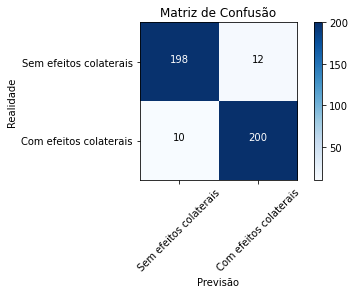

In [14]:
# rótulos de cada classe
cm_labels = ['Sem efeitos colaterais', 'Com efeitos colaterais']

# plotar a matriz
plot_cm(cm, cm_labels, title='Matriz de Confusão')

# Salvar e Carregar o modelo

$\textbf{.save}$: Salva a arquitetura do modelo, os pesos/parâmetros, a configuração de treinamento (função custo, optimizador), e o estado do optimizador (permite retomar o treino de onde você parou).

In [ ]:
model.save('medical_trial.h5')

In [ ]:
from keras.models import load_model

# carrega o modelo e tudo mais
new_model = load_model('medical_trial.h5')

new_model.summary()

In [ ]:
# outras informações
new_model.weights()
new_model.optimizer

$\textbf{.to_json}$: Guarda as informações apenas da arquitetura do modelo num string json.

In [ ]:
json_string = model.to_json()

# descomente pra ver como fica o string
#json_string

In [ ]:
from keras.models import model_from_json

# carrega a arquitetura a partir de um string json
model_arch = model_from_json(json_string)

model_arch.summary()

$\textbf{.save_weights}$: Salva apenas os valores dos pesos/parâmetros da rede.

In [ ]:
model.save_weights('medical_trial_weights.h5')

In [ ]:
# a partir da arquitetura correta, carrega os pesos
model_arch.load_weights('medical_trial_weights.h5')